### I have put in lots of work to make this notebook
-  refering to the important concepts mentioned in the **michael nielsen deep learning book** (chapter 1, chapter 2, chapter 3)
- I have tried my best to make a neural network class from the beginning my own without copying the code in the **michael nielsen** book.
- i have wanted to make a class that is similar in structure as the tensorflow library.

In [1]:
from sklearn.datasets import make_classification
import numpy as np

#### At the beginning i used a generated data using the **make_classification** library to test and debug my framework before trying it on the minist dataset.

In [2]:
n = 100
X, Y = make_classification(n_samples = n, n_features=7,
                           n_redundant=0, n_informative=7, flip_y=0.0, n_classes=3)
X = X.astype(np.float32)
Y = Y.astype(np.int32)

train_x, test_x = np.split(X, [n*8//10])
train_labels, test_labels = np.split(Y, [n*8//10])

In [3]:
print(train_x[0:4])
# print(train_labels[10:13])

[[-2.9715028  -2.111734    2.6699836  -0.89083135 -4.324263    0.09723637
  -0.68138725]
 [-2.4533546  -1.1386522   0.14909688  0.9929887  -1.5600386  -1.7178034
   0.59493536]
 [-3.0627162  -0.7382625   1.085122   -0.42586046  2.318875   -0.84472156
   0.43813038]
 [ 1.3751217   1.7328203   1.7510338  -1.2073286   0.01872577  0.15517184
  -0.5734819 ]]


## Making a layer class

- representing the linear layers of the neural network

- Its functions:
    1. forward(x): Computes the weighted input (z) and applies the sigmoid activation if enabled.
    2. backward(dz): Computes gradients for weights (dW), biases (db), and the input (dx) using the chain rule.
    3. update(lr): Updates the weights and biases using the computed gradients and the learning rate.

- have made a built in sigmoid boolean in each layer that can activate the sigmoid functions for the outputs of the neurons in the layer if set to TRUE


In [17]:
class Layer:
    def __init__(self, nin, nout, sigmoid = False):
        self.sigmoid = sigmoid
        self.W = np.random.normal(0, 1.0/np.sqrt(nin), (nout, nin))
        self.b = np.zeros((1,nout))
        
    def forward(self, x):
        self.x = x
        z = np.dot(x, self.W.T) + self.b

        if self.sigmoid: return 1.0/(1.0+np.exp(-z))
        return z
    
    def backward(self, dz):
        dx = np.dot(dz, self.W)
        dW = np.dot(dz.T, self.x)
        db = dz.sum(axis=0)
        self.dW = dW
        self.db = db
        return dx
    
    def update(self,lr):
        self.W -= lr*self.dW
        self.b -= lr*self.db
    
    
mod = Layer(7,3, sigmoid = True)
# net.forward(train_x[0])
print(mod.W)

[[ 0.50962547  0.16957474  0.08069371 -0.27969603  0.3778904  -0.07800394
   0.2465736 ]
 [-0.54821106 -0.10888825  0.44066916  0.10480896 -0.55485027 -0.22940648
   0.04730613]
 [-0.8473482  -0.09613679  0.02987103 -0.33097631  0.23691839  0.21238879
   0.30154372]]


## Softmax
as described in the book(chapter 3)

- The idea of softmax is to define a new type of output layer for our neural networks. It begins in the same way as with a sigmoid layer. However, we don't apply the sigmoid function to get the output. Instead, in a softmax layer we apply the so-called softmax function which changes the output of the neuron as follows:  

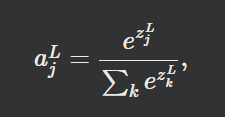

- So basically it changes the output of the neuron into a probability

> Note  I have used Softmax instead of Sigmoid in my training as it was working better for me 

In [18]:
class Softmax:

    def forward(self,z):
        self.z = z
        zmax = z.max(axis=1,keepdims=True)
        expz = np.exp(z-zmax)
        Z = expz.sum(axis=1,keepdims=True)
        return expz / Z
    
    def backward(self,dp):
        p = self.forward(self.z)
        pdp = p * dp
        return pdp - p * pdp.sum(axis=1, keepdims=True)

softmax = Softmax()
z2 = softmax.forward(mod.forward(train_x[0:10]))

## Cross Entropy cost function

- As mentioned in the book (chapter 3) Cross Entropy is one of the best loss functions we can use in a multi layer perceptron

- The cross-entropy cost function has the benefit that, unlike the quadratic cost, it avoids the problem of learning slowing down.

- The cross-entropy cost function is defined by

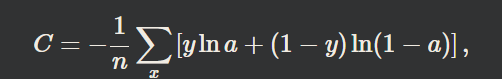

In [19]:
class CrossEntropyLoss:
    def forward(self,p,y):
        self.p = p
        self.y = y
        p_of_y = p[np.arange(len(y)), y]
        log_prob = np.log(p_of_y)
        return -log_prob.mean()
    
    def backward(self,loss):
        dlog_softmax = np.zeros_like(self.p)
        dlog_softmax[np.arange(len(self.y)), self.y] -= 1.0/len(self.y)
        return dlog_softmax / self.p
    
cross_ent_loss = CrossEntropyLoss()
p = softmax.forward(train_x[0:10])

print(train_labels[0:3])
# p = np.array([[0, 0, 1],
#               [1, 0, 0],
#               [0,0,1]])

cross_ent_loss.forward(p,train_labels[0:3])
# cross_ent(z2, train_labels[0:10])

[0 0 0]


5.318873

## Unlinearity functions

- In multilayer nertworks we have to put functions between layers that introduce unlinearity to the layer instead of all the layers acting as just one layer.  
> I still don't really understand how these functions do it

- Two of the most used activation functions are **Tanh**, **Relu**
#### Tanh
- it calculate the tanh for the output   
#### Relu
- it return the maximum between the uotput and some number as zero


In [20]:
class Tanh:
    def forward(self,x):
        y = np.tanh(x)
        self.y = y
        return y
    def backward(self,dy):
        return (1.0-self.y**2)*dy
    
class Relu:
    def forward(self, x):
        self.y = np.maximum(0, x) 
        return self.y

    def backward(self, dy):
        return (self.y > 0) * dy 
    
# T = Tanh()
# T.forward()
# r = Relu()


In [21]:
z = mod.forward(train_x[0:10])
p = softmax.forward(z)
loss = cross_ent_loss.forward(p,train_labels[0:10])
print(loss)

1.2960994958853034


In [171]:
# lin1 = Layer(7,7)
# lin2 = Layer(7,2)
# softmax = Softmax()
# cross_ent_loss = CrossEntropyLoss()

# learning_rate = 0.1

# pred = np.argmax(lin2.forward(lin1.forward(train_x)),axis=1)
# acc = (pred==train_labels).mean()
# print(acc)


# batch_size=4
# epochs = 4
# for j in range(epochs):
#     for i in range(0,len(train_x),batch_size):
#         xb = train_x[i:i+batch_size]
#         yb = train_labels[i:i+batch_size]
        
#         # forward pass
#         z1 = lin1.forward(xb)
#         z = lin2.forward(z1)

#         p = softmax.forward(z)
#         loss = cross_ent_loss.forward(p,yb)
        
#         # backward pass
#         dp = cross_ent_loss.backward(loss)
#         dz2 = softmax.backward(dp)
#         dz = lin2.backward(dz2)
#         lin2.update(learning_rate)
#         dx = lin1.backward(dz)
#         lin1.update(learning_rate)
        
#     pred = np.argmax(lin1.forward(train_x),axis=1)
#     acc = (pred==train_labels).mean()
#     print(acc)

## Neural Network Class  

Now i will make a class that will represent our NN model by adding the layer we want together

- It will have the following functions 

1. forward: makes predictions for our model 
2. backward: Makes the back propagation for our model 
**Back propagation** is the process of knowing how to adjust the wights and biases in the network to reduce the loss function output. It was explained in **Chapter Two**. it works by making backward derivatvies using the chain rule through out the whole model layers.

> The backward functions in the model was understood and took from the concepts of the functions in [this REPO](https://github.com/microsoft/etrain)

In [22]:
class Model:
    def __init__(self):
        self.layers = []
    
    def add(self,l):
        self.layers.append(l)
        
    def forward(self,x):
        for l in self.layers:
            x = l.forward(x)
        return x
    
    def backward(self,z):
        for l in self.layers[::-1]:
            z = l.backward(z)
        return z
    
    def update(self,lr):
        for l in self.layers:
            if 'update' in l.__dir__():
                l.update(lr)

## Training 
- Defining a function that takes data with its corresponding labels and strt training the model

In [23]:
def get_loss_acc(mod, x,y,loss=CrossEntropyLoss()): ## Return the cost, accuaracy
    p = mod.forward(x)
    l = loss.forward(p,y)
    pred = np.argmax(p,axis=1)
    acc = (pred==y).mean()
    return l,acc

def train_model(model, train_data, valid_data, loss=CrossEntropyLoss(),epochs = 5, batch_size=16, lr=0.01):
    for x in range (epochs):
        for j in range(0,len(train_x),batch_size):
            i = np.random.choice(range(0,len(train_x)-batch_size-1) )
            xb = train_x[i:i+batch_size]
            yb = train_labels[i:i+batch_size]

            p = model.forward(xb)
            l = loss.forward(p,yb)
            dp = loss.backward(l)
            dx = model.backward(dp)
            model.update(lr)

        losss, acc = get_loss_acc(model, train_data[0],train_data[1])
        print(f"\nepochs: {x+1}, accuracy: {acc}, loss:{losss} ",end =" ")
        losss, acc = get_loss_acc(model, valid_data[0],valid_data[1])
        print(f"Validation accuracy: {acc}, Validation loss:{losss} \n")

In [24]:
model1 = Model()
model1.add(Layer(7,3))
model1.add(Softmax())
loss = CrossEntropyLoss()

losss, acc = get_loss_acc(model1, train_x,train_labels)
print(f"Initial loss={acc}, accuracy={losss}: ")

 
train_model(model1,(train_x, train_labels),(test_x, test_labels), epochs=11, lr = 0.05)


Initial loss=0.375, accuracy=2.3371403184710347: 

epochs: 1, accuracy: 0.375, loss:1.9159618118865758  Validation accuracy: 0.5, Validation loss:1.3940783827631038 


epochs: 2, accuracy: 0.425, loss:1.587068386321603  Validation accuracy: 0.5, Validation loss:1.1629232281768278 


epochs: 3, accuracy: 0.4375, loss:1.3391755131500758  Validation accuracy: 0.5, Validation loss:1.0176446305777618 


epochs: 4, accuracy: 0.4875, loss:1.162060125015866  Validation accuracy: 0.5, Validation loss:0.9331793373751648 


epochs: 5, accuracy: 0.55, loss:1.0110706761760344  Validation accuracy: 0.55, Validation loss:0.8233795881331195 


epochs: 6, accuracy: 0.5875, loss:0.899450580213014  Validation accuracy: 0.6, Validation loss:0.77780405210772 


epochs: 7, accuracy: 0.625, loss:0.8573997806397495  Validation accuracy: 0.6, Validation loss:0.766422415227524 


epochs: 8, accuracy: 0.6375, loss:0.822388947894359  Validation accuracy: 0.6, Validation loss:0.753445161204735 


epochs: 9, accura

## Works good enough

- we can see the accuracy increasing and the loss decreasing

### Now i will try to make a larger model using my framework and train it on the minist data sat

In [25]:
from tensorflow import keras

(train_x, train_labels), (test_x, test_labels) = keras.datasets.mnist.load_data()
train_x = train_x.reshape(60000, 28 * 28)
test_x = test_x.reshape(10000, 28 * 28)

#### i reshaped the data set to convert it into a 1D vector which my model can train

In [27]:
model2 = Model()
model2.add(Layer(28*28,36))
model2.add(Tanh())
# model2.add(Relu)
model2.add(Layer(36,10))
model2.add(Tanh())

model2.add(Softmax())
loss = CrossEntropyLoss()

losss, acc = get_loss_acc(model2, train_x,train_labels)
print(f"Initial loss={losss}, accuracy={acc}: ")

 
train_model(model2,(train_x, train_labels),(test_x, test_labels), epochs=5, lr = 0.02, batch_size=32)


Initial loss=2.499090246396412, accuracy=0.10285: 

epochs: 1, accuracy: 0.66715, loss:1.4319905056684998  Validation accuracy: 0.6791, Validation loss:1.4182191129234991 


epochs: 2, accuracy: 0.7178, loss:1.332650129624932  Validation accuracy: 0.7262, Validation loss:1.326334270707869 


epochs: 3, accuracy: 0.7322833333333333, loss:1.296286742999343  Validation accuracy: 0.7377, Validation loss:1.2827135682284705 



## The FrameWork works Good 